In [2]:
using JuMP, Statistics
using Gurobi,JuMPeR,LinearAlgebra,SparseArrays
# using DataFrames, IndexedTables
# using Distributions

In [1]:
using OpenStreetMapX
map_data = get_map_data("graph.osm");

println("The map contains $(length(map_data.nodes)) nodes")

┌ Info: Precompiling OpenStreetMapX [86cd37e6-c0ff-550b-95fe-21d72c8d4fc9]
└ @ Base loading.jl:1260
┌ Info: Saved map data to cache graph.osm.cache
└ @ OpenStreetMapX C:\Users\24829\.julia\packages\OpenStreetMapX\jQrP5\src\parseMap.jl:140


The map contains 0 nodes


In [24]:

n, C, Γ = 10, 3, 4
p, w = rand(n), rand(n)
σ = 0.2 * rand(n) .* w
knap = RobustModel()
@variable(knap,      x[1:n], Bin)
@uncertain(knap, 0 <= z[1:n] <= 1)

@addConstraint(knap, sum{(w[i]+σ[i]*z[i])*x[i], i=1:n} <= C)
@addConstraint(knap, sum{z[i], i=1:n} <= Γ)

@setObjective(knap, Max, sum{p[i]*x[i], i=1:n})

solve(knap)

┌ Warning: @addConstraint is deprecated, use @constraint instead.
│   caller = eval at boot.jl:331 [inlined]
└ @ Core .\boot.jl:331


LoadError: In @constraint($(Expr(:escape, :(sum{(w[i] + σ[i] * z[i]) * x[i], i = 1:n} <= C)))): Not enough arguments

In [36]:
@variable(knap,      x[1:n], Bin)
@uncertain(knap, 0 <= z[1:n] <= 1)
@setObjective(knap, Max, sum{p[i]*x[i], i=1:n})

┌ Warning: A variable or constraint named x is already attached to this model. If creating variables programmatically, use the anonymous variable syntax x = @variable(m, [1:N], ...).
└ @ JuMP C:\Users\24829\.julia\packages\JuMP\I7whV\src\JuMP.jl:857


LoadError: in @objective: needs three arguments: model, objective sense (Max or Min) and expression.

In [12]:
s=5
k=3
mod= RobustModel(solver=GurobiSolver())
@uncertain(mod,ξ[i=1:k,j=1:s])
@adaptive(mod,ext[1:k], policy=Affine, depends_on=ξ[1:k])
# @variable(mod, obj)
# @setObjective(mod, Max, obj)

3-element Array{JuMPeR.Adaptive,1}:
 JuMPeR.Adaptive(Feasibility problem with:
 * 0 linear constraints
 * 0 variables
Solver is Gurobi, 1)
 JuMPeR.Adaptive(Feasibility problem with:
 * 0 linear constraints
 * 0 variables
Solver is Gurobi, 2)
 JuMPeR.Adaptive(Feasibility problem with:
 * 0 linear constraints
 * 0 variables
Solver is Gurobi, 3)

In [7]:
# using CSVFiles, DataFrames
# df = DataFrame(load("nyc-taxi-trip-duration\\train.csv"))
first(df,6)
# show(df, allcols=true)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count
,String,Int64,Dates.D…,Dates.D…,Int64
1,id2875421,2,2016-03-14T17:24:55,2016-03-14T17:32:30,1
2,id2377394,1,2016-06-12T00:43:35,2016-06-12T00:54:38,1
3,id3858529,2,2016-01-19T11:35:24,2016-01-19T12:10:48,1
4,id3504673,2,2016-04-06T19:32:31,2016-04-06T19:39:40,1
5,id2181028,2,2016-03-26T13:30:55,2016-03-26T13:38:10,1
6,id0801584,2,2016-01-30T22:01:40,2016-01-30T22:09:03,6


In [11]:
names(df)

11-element Array{String,1}:
 "id"
 "vendor_id"
 "pickup_datetime"
 "dropoff_datetime"
 "passenger_count"
 "pickup_longitude"
 "pickup_latitude"
 "dropoff_longitude"
 "dropoff_latitude"
 "store_and_fwd_flag"
 "trip_duration"

### 鲁棒优化

In [3]:
# Nominal Problem
function NominalProblem(n,μ,δ)
    NetworkModel = Model(solver=GurobiSolver(OutputFlag=0))
    capacity = (ones(n,n)-Matrix{Float64}(I, n, n))*0.5
    capacity[1,n] = 0
    capacity[n,1] = 0
    @variable(NetworkModel, flow[i=1:n,j=1:n]>=0)
    @constraint(NetworkModel, flow .<= capacity)
    @constraint(NetworkModel, sum(flow[1,i] for i=1:n)==1)
    @constraint(NetworkModel, sum(flow[i,n] for i=1:n)==1)
    for j = 2:n-1
        @constraint(NetworkModel, sum(flow[i,j] for i=1:n) == sum(flow[j,k] for k=1:n)  )
    end
    @objective(NetworkModel,Min, sum(flow[i,j]*μ[i,j] for i=1:n for j=1:n) );
    solve(NetworkModel)
    return getvalue(flow)
end


NominalProblem (generic function with 1 method)

In [2]:
# {\hat{T}}_{od}(\mathbf{t})={min}\below{p_{od}\in\mathcal{P}_{od}}\sum_{(i,j)\in P_{od}} t_{ij}

In [4]:
# Robust Problem
function RobustProblem(m,o,d,z,λ,norm_type)
    NetworkModel_robust = RobustModel(solver=GurobiSolver(OutputFlag=0))
    @variable(NetworkModel_robust, n[o=1:m,d=1:m]>=0)
    @variable(NetworkModel_robust, x[o=1:m,d=1:m]>=0)
    # 不确定集的变量
    @uncertain(NetworkModel_robust, t[i=1:m,j=1:m])
    
    @variable(NetworkModel_robust, obj) 
    ptintln(a_star(mgw, o[z], d[z]))
    @constraint(NetworkModel_robust, T[i,j] = mgw[z,:trip_duration] )
    @constraint(NetworkModel_robust, T[i,j] >=sum(t[i,j]) )
    @constraint(NetworkModel_robust, x[o,d]+T[i,j] >=norm([T[o,d]-x[o,d],
                                                            2*sqrt(T[o,d])],2))
    @constraint(NetworkModel_robust, t[i,j] >= fastest_route(o,d))
    
    d[i,j] = shortest_route(map_data,o,d)[2] 
    regularization = λ*sum{ abs(t[i,j]/d[i,j]-t[i-1,l]/d[i-1,l]) * 2/(d[k,l]+d[i-1,j-1]) }
    @objective(NetworkModel_robust, Min, n[o,d]*x[o,d] + regularization)
    solve(NetworkModel_robust)
    return getvalue(t,λ)
end

RobustProblem (generic function with 1 method)

In [ ]:
# 算法部分
# for o,d,i,j in zip(mgw[:Origin,:Destination,])

In [ ]:
# function RobustProblem(n,μ,δ,Γ,norm_type)
#     NetworkModel_robust = RobustModel(solver=GurobiSolver(OutputFlag=0))

#     @variable(NetworkModel_robust, n[o=1:n,d=1:n]>=0)
#     # 不确定集的变量
#     @uncertain(NetworkModel_robust, cost[i=1:n,j=1:n])
#     @uncertain(NetworkModel_robust, r[i=1:n,j=1:n])
    
#     @variable(NetworkModel_robust, obj) 
    
#     for i = 1:n
#         for j = 1:n
#         @constraint(NetworkModel_robust, cost[i,j] == μ[i,j]+r[i,j]*δ[i,j])
#         end
#     end  
#     @constraint(NetworkModel_robust, norm(r,norm_type) <= Γ)
#     @constraint(NetworkModel_robust, flow .<= capacity)
#     @constraint(NetworkModel_robust, sum(flow[1,i] for i=1:n) == 1)
#     @constraint(NetworkModel_robust, sum(flow[i,n] for i=1:n) == 1)
#     for j = 2:n-1
#         @constraint(NetworkModel_robust, sum(flow[i,j] for i=1:n) == sum(flow[j,k] for k=1:n))
#     end
#     @constraint(NetworkModel_robust, sum(cost[i,j]*flow[i,j] for i=1:n for j=1:n) <= obj )
#     @objective(NetworkModel_robust, Min, obj)
#     solve(NetworkModel_robust)
#     return getvalue(flow)
# end

In [48]:
@variable(NetworkModel_robust, flow[i=1:n,j=1:n]>=0)

┌ Warning: A variable or constraint named flow is already attached to this model. If creating variables programmatically, use the anonymous variable syntax x = @variable(m, [1:N], ...).
└ @ JuMP C:\Users\24829\.julia\packages\JuMP\I7whV\src\JuMP.jl:857


10×10 Array{Variable,2}:
 flow[1,1]   flow[1,2]   flow[1,3]   …  flow[1,8]   flow[1,9]   flow[1,10]
 flow[2,1]   flow[2,2]   flow[2,3]      flow[2,8]   flow[2,9]   flow[2,10]
 flow[3,1]   flow[3,2]   flow[3,3]      flow[3,8]   flow[3,9]   flow[3,10]
 flow[4,1]   flow[4,2]   flow[4,3]      flow[4,8]   flow[4,9]   flow[4,10]
 flow[5,1]   flow[5,2]   flow[5,3]      flow[5,8]   flow[5,9]   flow[5,10]
 flow[6,1]   flow[6,2]   flow[6,3]   …  flow[6,8]   flow[6,9]   flow[6,10]
 flow[7,1]   flow[7,2]   flow[7,3]      flow[7,8]   flow[7,9]   flow[7,10]
 flow[8,1]   flow[8,2]   flow[8,3]      flow[8,8]   flow[8,9]   flow[8,10]
 flow[9,1]   flow[9,2]   flow[9,3]      flow[9,8]   flow[9,9]   flow[9,10]
 flow[10,1]  flow[10,2]  flow[10,3]     flow[10,8]  flow[10,9]  flow[10,10]

In [52]:
@constraint(NetworkModel_robust, flow .<= capacity)

10×10 Array{ConstraintRef{Model,JuMP.GenericRangeConstraint{JuMP.GenericAffExpr{Float64,Variable}}},2}:
 flow[1,1] <= 0     flow[1,2] <= 0.5   …  flow[1,10] <= 0.5
 flow[2,1] <= 0.5   flow[2,2] <= 0        flow[2,10] <= 0.5
 flow[3,1] <= 0.5   flow[3,2] <= 0.5      flow[3,10] <= 0.5
 flow[4,1] <= 0.5   flow[4,2] <= 0.5      flow[4,10] <= 0.5
 flow[5,1] <= 0.5   flow[5,2] <= 0.5      flow[5,10] <= 0.5
 flow[6,1] <= 0.5   flow[6,2] <= 0.5   …  flow[6,10] <= 0.5
 flow[7,1] <= 0.5   flow[7,2] <= 0.5      flow[7,10] <= 0.5
 flow[8,1] <= 0.5   flow[8,2] <= 0.5      flow[8,10] <= 0.5
 flow[9,1] <= 0.5   flow[9,2] <= 0.5      flow[9,10] <= 0.5
 flow[10,1] <= 0.5  flow[10,2] <= 0.5     flow[10,10] <= 0

In [53]:
@uncertain(NetworkModel_robust, r[i=1:n,j=1:n])

10×10 Array{JuMPeR.Uncertain,2}:
 r[1,1]   r[1,2]   r[1,3]   r[1,4]   …  r[1,7]   r[1,8]   r[1,9]   r[1,10]
 r[2,1]   r[2,2]   r[2,3]   r[2,4]      r[2,7]   r[2,8]   r[2,9]   r[2,10]
 r[3,1]   r[3,2]   r[3,3]   r[3,4]      r[3,7]   r[3,8]   r[3,9]   r[3,10]
 r[4,1]   r[4,2]   r[4,3]   r[4,4]      r[4,7]   r[4,8]   r[4,9]   r[4,10]
 r[5,1]   r[5,2]   r[5,3]   r[5,4]      r[5,7]   r[5,8]   r[5,9]   r[5,10]
 r[6,1]   r[6,2]   r[6,3]   r[6,4]   …  r[6,7]   r[6,8]   r[6,9]   r[6,10]
 r[7,1]   r[7,2]   r[7,3]   r[7,4]      r[7,7]   r[7,8]   r[7,9]   r[7,10]
 r[8,1]   r[8,2]   r[8,3]   r[8,4]      r[8,7]   r[8,8]   r[8,9]   r[8,10]
 r[9,1]   r[9,2]   r[9,3]   r[9,4]      r[9,7]   r[9,8]   r[9,9]   r[9,10]
 r[10,1]  r[10,2]  r[10,3]  r[10,4]     r[10,7]  r[10,8]  r[10,9]  r[10,10]

In [56]:
@constraint(NetworkModel_robust, norm(r,Inf) <= Γ)

ConstraintRef{JuMPeR.BasicUncertaintySet,JuMP.GenericRangeConstraint{JuMP.GenericAffExpr{Float64,JuMPeR.Uncertain}}}(JuMPeR.BasicUncertaintySet(false, JuMP.GenericRangeConstraint{JuMP.GenericAffExpr{Float64,JuMPeR.Uncertain}}[], JuMPeR.UncSetNormConstraint[‖r[1,1],r[2,1],r[3,1],r[4,1],r[5,1],r[6,1],r[7,1],r[8,1],r[9,1],r[10,1],r[1,2],r[2,2],r[3,2],r[4,2],r[5,2],r[6,2],r[7,2],r[8,2],r[9,2],r[10,2],r[1,3],r[2,3],r[3,3],r[4,3],r[5,3],r[6,3],r[7,3],r[8,3],r[9,3],r[10,3],r[1,4],r[2,4],r[3,4],r[4,4],r[5,4],r[6,4],r[7,4],r[8,4],r[9,4],r[10,4],r[1,5],r[2,5],r[3,5],r[4,5],r[5,5],r[6,5],r[7,5],r[8,5],r[9,5],r[10,5],r[1,6],r[2,6],r[3,6],r[4,6],r[5,6],r[6,6],r[7,6],r[8,6],r[9,6],r[10,6],r[1,7],r[2,7],r[3,7],r[4,7],r[5,7],r[6,7],r[7,7],r[8,7],r[9,7],r[10,7],r[1,8],r[2,8],r[3,8],r[4,8],r[5,8],r[6,8],r[7,8],r[8,8],r[9,8],r[10,8],r[1,9],r[2,9],r[3,9],r[4,9],r[5,9],r[6,9],r[7,9],r[8,9],r[9,9],r[10,9],r[1,10],r[2,10],r[3,10],r[4,10],r[5,10],r[6,10],r[7,10],r[8,10],r[9,10],r[10,10]‖∞ <= 4], Feasibility p

In [7]:
function Evaluation()
    n_type = [10,25,50,75,100]
    Γ_type = [1e-4,1e-1,1e1,1e4]
    report_data = zeros(13,5)
    for n_idx = 1:5
        n = n_type[n_idx]
        count = 2
        μ = 10*rand(n,n)
        δ = zeros(n,n)
        for i = 1:n
            for j = 1:n
                δ[i,j] = μ[i,j]*rand()
            end
        end
        cost_sim = zeros(n,n)
                for i = 1:n
                    for j = 1:n
                        cost_sim[i,j] = μ[i,j] + δ[i,j] * (rand()-0.5) * 2
                    end
                end
        sol_0 = NominalProblem(n,μ,δ)
        report_data[1,n_idx] = sum(sum(cost_sim.*sol_0))
        for Γ in Γ_type
            print("n=",n,  "Γ=",Γ)
            sol_inf = RobustProblem(n,μ,δ,Γ,Inf)
            sol_1 = RobustProblem(n,μ,δ,Γ,1)
            sol_2 = RobustProblem(n,μ,δ,Γ,2)    
            report_data[count,n_idx] = sum(sum(cost_sim.*(sol_inf-sol_0)))
            report_data[count+1,n_idx] = sum(sum(cost_sim.*(sol_1-sol_0) ))
            report_data[count+2,n_idx] = sum(sum(cost_sim.*(sol_2-sol_0) ))
            count = count + 3
        end
    end
    return report_data
end

output = Evaluation();


n=10Γ=0.0001n=10Γ=0.1n=10Γ=10.0n=10Γ=10000.0n=25Γ=0.0001n=25Γ=0.1n=25Γ=10.0n=25Γ=10000.0n=50Γ=0.0001n=50Γ=0.1n=50Γ=10.0n=50Γ=10000.0n=75Γ=0.0001n=75Γ=0.1n=75Γ=10.0n=75Γ=10000.0n=100Γ=0.0001n=100Γ=0.1n=100Γ=10.0n=100Γ=10000.0

In [12]:
output

13×5 Array{Float64,2}:
 5.09269      2.09675      0.920964     1.23845     0.632904
 0.0          0.0          0.0          0.0         0.0
 0.0          0.0          0.0          0.0         0.0
 1.20397e-7   4.25705e-8   2.69176e-8   7.46415e-9  7.55819e-9
 0.0          0.0          0.0          0.0         0.0
 0.0          0.0          0.0          0.0         0.0
 1.6556e-8   -2.54838e-6   2.08303e-8  -2.69939e-8  2.06232e-7
 0.0          0.648536     0.124022     0.188586    0.163508
 2.30528      0.972108     0.209148     0.0261533   0.113444
 1.58461      0.788783     0.186773     0.180756    0.138274
 0.0          5.51162     10.983        6.41142     4.81391
 3.14532      3.55501      5.71182      1.70063     2.97145
 4.89285      7.92969     12.756        5.278       7.78682

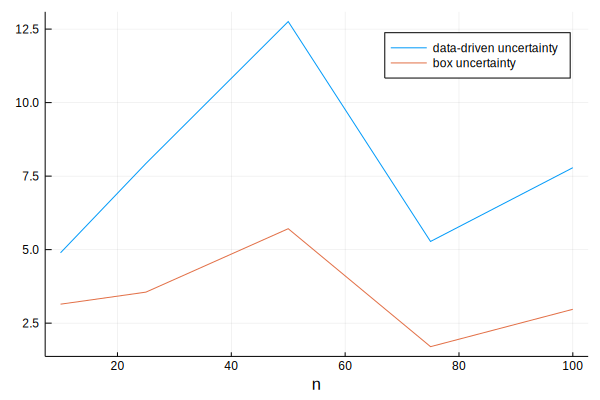

In [82]:
# 输出Γ=10时三种uncertainty set给出的difference
using Plots
temp_p = plot([10,25,50,75,100],output[13,:],xlabel = "n", label = "data-driven uncertainty")
plot!(temp_p,[10,25,50,75,100],output[12,:], label = "box uncertainty")
# plot!(temp_p,[10,25,50,75,100],output[11,:], label = "U2")

### 可视化

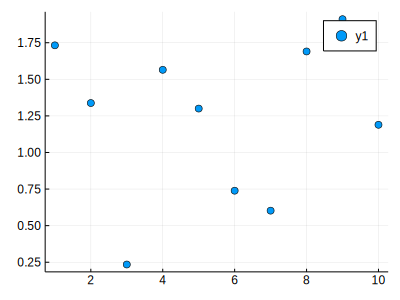

In [18]:
# using StatsPlots # no need for `using Plots` as that is reexported here
gr(size=(400,300))
using StatsPlots: @df, StatsPlots
using DataFrames, IndexedTables
df = DataFrame(a = 1:10, b = 10 .* rand(10), c = 10 .* rand(10))
@df df plot(:a, [:b :c], colour = [:red :blue])
@df df scatter(:a, :b, markersize = 4 .* log.(:c .+ 0.1))
t = table(1:10, rand(10), names = [:a, :b]) # IndexedTable
@df t scatter(2 .* :b)

In [20]:
using Plots
# define the Lorenz attractor
Base.@kwdef mutable struct Lorenz
    dt::Float64 = 0.02
    σ::Float64 = 10
    ρ::Float64 = 28
    β::Float64 = 8/3
    x::Float64 = 1
    y::Float64 = 1
    z::Float64 = 1
end

function step!(l::Lorenz)
    dx = l.σ * (l.y - l.x);         l.x += l.dt * dx
    dy = l.x * (l.ρ - l.z) - l.y;   l.y += l.dt * dy
    dz = l.x * l.y - l.β * l.z;     l.z += l.dt * dz
end

attractor = Lorenz()


# initialize a 3D plot with 1 empty series
plt = plot3d(
    1,
    xlim = (-30, 30),
    ylim = (-30, 30),
    zlim = (0, 60),
    title = "Lorenz Attractor",
    marker = 2,
)

# build an animated gif by pushing new points to the plot, saving every 10th frame
@gif for i=1:1500
    step!(attractor)
    push!(plt, attractor.x, attractor.y, attractor.z)
end every 10

### 练习部分---（非正式）

In [5]:
m = RobustModel(solver=GurobiSolver(OutputFlag=0))

Feasibility problem with:
 * 0 linear constraints
 * 0 variables
Solver is Gurobi

In [ ]:
ENV["CPLEX_STUDIO_BINARIES"] = "C:\Program Files\IBM\ILOG\CPLEX_Studio1210\cplex\bin\x64_win64" 

In [2]:
function CarpenterPrimal(c,A,b)
    # 定义Model对象, OutputFlag = 0指不输出log
    Primal = Model(solver = GurobiSolver(OutputFlag = 0))
    # 定义变量，注意这里使用了宏（macro），宏的调用也是Julia&JuMP高效编译/元编程(metaprogramming)的重要技巧
    @variable(Primal, x[1:2]>=0)
    # 定义不等式约束
    constr = @constraint(Primal, A*x.<=b)
    # 定义目标函数
    @objective(Primal, Max, dot(c,x))
    # 求解
    solve(Primal)
    # 返回最优目标函数值，最优解（原问题），最优解（对偶问题）
    return getobjectivevalue(Primal), getvalue(x), getdual(constr)
end

CarpenterPrimal (generic function with 1 method)

In [27]:
 Diagonal(ones(3,3))

3×3 Diagonal{Float64,Array{Float64,1}}:
 1.0   ⋅    ⋅ 
  ⋅   1.0   ⋅ 
  ⋅    ⋅   1.0

In [30]:
Matrix{Float64}(I, 2, 2)

2×2 Array{Float64,2}:
 1.0  0.0
 0.0  1.0

In [6]:
model = Model()

Feasibility problem with:
 * 0 linear constraints
 * 0 variables
Solver is default solver

In [23]:
@variable(model, x[1:2, 3:4])

x[i,j] for all i in {1,2}, j in {3,4}

In [28]:
@variable(model, x[1:2, [:A,:B]])

┌ Warning: A variable or constraint named x is already attached to this model. If creating variables programmatically, use the anonymous variable syntax x = @variable(m, [1:N], ...).
└ @ JuMP C:\Users\24829\.julia\packages\JuMP\I7whV\src\JuMP.jl:857


x[i,j] for all i in {1,2}, j in {A,B}

In [30]:
x[1, :A]

x[1,A]

In [31]:
@variable(model, x[i=2:3, j=1:2:3] >= 0.5i + j)

┌ Warning: A variable or constraint named x is already attached to this model. If creating variables programmatically, use the anonymous variable syntax x = @variable(m, [1:N], ...).
└ @ JuMP C:\Users\24829\.julia\packages\JuMP\I7whV\src\JuMP.jl:857


x[i,j] >= .. for all i in {2,3}, j in {1,3}

In [34]:
@variable(model, x[i=2:3, j=1:2:3] >= 0.5i + j)
@variable(model, x[i=1:2, j=i:2])

┌ Warning: A variable or constraint named x is already attached to this model. If creating variables programmatically, use the anonymous variable syntax x = @variable(m, [1:N], ...).
└ @ JuMP C:\Users\24829\.julia\packages\JuMP\I7whV\src\JuMP.jl:857
┌ Warning: A variable or constraint named x is already attached to this model. If creating variables programmatically, use the anonymous variable syntax x = @variable(m, [1:N], ...).
└ @ JuMP C:\Users\24829\.julia\packages\JuMP\I7whV\src\JuMP.jl:857


x[i,j] for all i in {1,2}, j in {..}

In [35]:
@variable(model, x[i=1:4; mod(i, 2)==0])

┌ Warning: A variable or constraint named x is already attached to this model. If creating variables programmatically, use the anonymous variable syntax x = @variable(m, [1:N], ...).
└ @ JuMP C:\Users\24829\.julia\packages\JuMP\I7whV\src\JuMP.jl:857


x[i] for all i in {1,2,3,4} s.t. mod(i, 2) == 0

In [27]:
@variable(model, x[i=1:2, j=1:2] >= 2i + j)

┌ Warning: A variable or constraint named x is already attached to this model. If creating variables programmatically, use the anonymous variable syntax x = @variable(m, [1:N], ...).
└ @ JuMP C:\Users\24829\.julia\packages\JuMP\I7whV\src\JuMP.jl:857


2×2 Array{Variable,2}:
 x[1,1]  x[1,2]
 x[2,1]  x[2,2]

In [9]:
N = 10
S = [(1, 1, 1),(N, N, N)]
# Slow. It evaluates conditional N^3 times.
@variable(model, x1[i=1:N, j=1:N, k=1:N; (i, j, k) in S])

x1[i,j,k] for all i in {1,2,..,9,10}, j in {1,2,..,9,10}, k in {1,2,..,9,10} s.t. (i, j, k) in S

In [10]:
x3 = Dict()
for (i, j, k) in S
    x3[i, j, k] = @variable(model)
    # Optional, if you care about pretty printing:
    set_name(x3[i, j, k], "x[$i,$j,$k]")
end

UndefVarError: UndefVarError: set_name not defined

In [14]:
m = Model()
n = 2

2

In [38]:
@variables m begin
    x
    y >= 0
    z
    Z[1:10], Bin
    X[1:3,1:3], SDP
    q[i=1:2], (lowerbound = i, start = 2i, upperbound = 3i)
    t[j=1:3], (Int, start = j)
end

┌ Warning: A variable or constraint named x is already attached to this model. If creating variables programmatically, use the anonymous variable syntax x = @variable(m, [1:N], ...).
└ @ JuMP C:\Users\24829\.julia\packages\JuMP\I7whV\src\JuMP.jl:857
┌ Warning: A variable or constraint named y is already attached to this model. If creating variables programmatically, use the anonymous variable syntax x = @variable(m, [1:N], ...).
└ @ JuMP C:\Users\24829\.julia\packages\JuMP\I7whV\src\JuMP.jl:857
┌ Warning: A variable or constraint named z is already attached to this model. If creating variables programmatically, use the anonymous variable syntax x = @variable(m, [1:N], ...).
└ @ JuMP C:\Users\24829\.julia\packages\JuMP\I7whV\src\JuMP.jl:857
┌ Warning: A variable or constraint named Z is already attached to this model. If creating variables programmatically, use the anonymous variable syntax x = @variable(m, [1:N], ...).
└ @ JuMP C:\Users\24829\.julia\packages\JuMP\I7whV\src\JuMP.jl:857


In [39]:
aff = AffExpr([x, z], [3.0, 4.0], 2.0)
# quad = QuadExpr([x,y],[x,],[3.0,4.0],aff)

3 x + 4 z + 2

In [40]:
@constraints(m, begin
  x >= 1
  y - z <= 2
  sum_to_one[i=1:3], z[i] + y == 1
end)

MethodError: MethodError: no method matching getindex(::Variable, ::Int64)

In [53]:
@variable(model, x, Bin)

┌ Warning: A variable or constraint named x is already attached to this model. If creating variables programmatically, use the anonymous variable syntax x = @variable(m, [1:N], ...).
└ @ JuMP C:\Users\24829\.julia\packages\JuMP\I7whV\src\JuMP.jl:857


x

In [7]:
@variable(model, x[1:2, 1:2] in PSDCone())

LoadError: In @variable(model,x[1:2, 1:2] in PSDCone()): Unexpected syntax x[1:2, 1:2] in PSDCone().